## Operational Modal Analysis

By **Lorenzo Donadio**

This report outlines models of simple vibrating structures, the explorations of their characteristics i.e stifness, damping, natural frequencies, mode shapes, spectral responses. 

It also provides an implementation of two families of methods to identify modal parameters; Frequency Domain Decomposition (and peak picking) and SSICOV.

Here we provide the following files:

- `oma.py` : Implements the **EOM in matrix formulation**, mass, stiffness and damping, solves the eigenvalue problem and helps plot the **spectral response** of the structure
- `ssm.py` : The **State Space Model** formulation is derived from the output of the `oma` module, it also provide capabilities to analyze the resulting time series in the discrete time domain
- `fdd.py` : Provides helper fucntions for **Frequency Domain Decomposition** methods, to identify modal parameters
- `ssicov.py` : Implements the **SSICOV** method and stabilization diagram to better identify modal parameters, specially damping



In [1]:
import numpy as np
import pandas as pd

from scipy import signal
from scipy.signal import welch

import matplotlib.pyplot as plt

np.set_printoptions(suppress=True,precision=3)

from oma import OperationalModalAnalysis,plot_response_magnitude,plot_response_phase,plot_white_noise_response

The `OperationalModalAnalysis` class is imported along with helper functions.

several instances of the class will be created with different damping parameters

we can inspect the matrices of the EOMs, the natural frequecies and the mode shapes

In [2]:
nf = 4 # Number of Floors
m = 35 # Mass [kg]
k = 30_000 # Stiffness [N/m]

oma1 = OperationalModalAnalysis(nf=nf, m=m, k=k, zeta=0.005)
oma2 = OperationalModalAnalysis(nf=nf, m=m, k=k, zeta=0.01)
oma3 = OperationalModalAnalysis(nf=nf, m=m, k=k, zeta=0.05)

maxfreq = 10  # hz higher than the largest natural frequency
n_freq_points = 400 # this can change
ww = np.linspace(0, 2 * np.pi * maxfreq, n_freq_points) # omega vector
freq = ww/(2*np.pi)

1 DOF frequency (Hz): 4.65957961720501
Natural frequencies (Hz): [1.618 4.66  7.139 8.757]
1 DOF frequency (Hz): 4.65957961720501
Natural frequencies (Hz): [1.618 4.66  7.139 8.757]
1 DOF frequency (Hz): 4.65957961720501
Natural frequencies (Hz): [1.618 4.66  7.139 8.757]


In [3]:
print('Mass matrix \n', oma1.M)
print(40*'-'+'\nStiffness matrix \n', oma1.K)
print(40*'-'+'\nDamping matrix \n', oma1.C)

Mass matrix 
 [[35.  0.  0.  0.]
 [ 0. 35.  0.  0.]
 [ 0.  0. 35.  0.]
 [ 0.  0.  0. 35.]]
----------------------------------------
Stiffness matrix 
 [[ 60000. -30000.      0.      0.]
 [-30000.  60000. -30000.      0.]
 [     0. -30000.  60000. -30000.]
 [     0.      0. -30000.  30000.]]
----------------------------------------
Damping matrix 
 [[ 20.494 -10.247   0.      0.   ]
 [-10.247  20.494 -10.247   0.   ]
 [  0.    -10.247  20.494 -10.247]
 [  0.      0.    -10.247  10.247]]


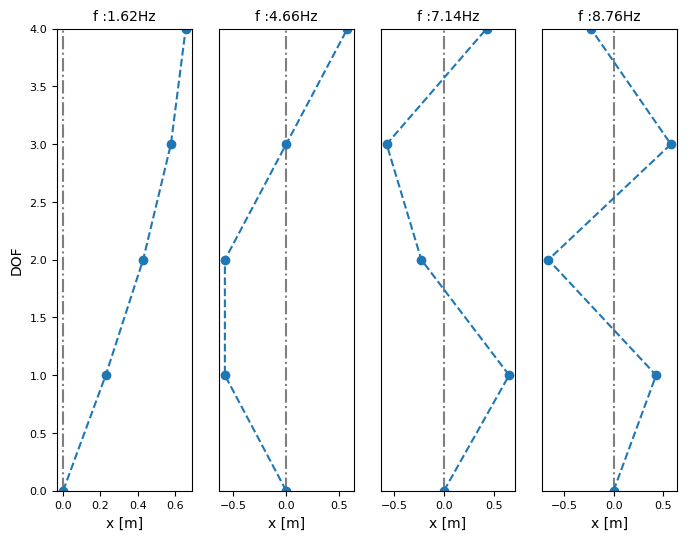

In [4]:
fig,ax = oma1.plot_modes()


For the second mode shape we can see that one node is zero, so this is a stationary node, This means this point will be static regarding that mode, and so an accelerometer placed at that height will be unable to capture that mode. 

Let us verify that by plotting the theoretical response functions in the frequency domain (transfer functions )

we use the `response_H_explicit` that calculates H as follows:

\begin{equation}
H_{(i,j)}(\omega) 
= \sum_{k=1}^{n_2} \frac{ (\varphi_i)_k \, (\varphi_j)_k }
{\omega_k^2 - \omega^2 + 2\,i\,\zeta_k\,\omega\,\omega_k}
\end{equation}

`oma` also provides the `response_H_inv` for : 

\begin{equation}
H(\omega) 
= \bigl[-\omega^2 M + i \omega C + K \bigr]^{-1}
\end{equation}

But this implies the calculation of an inverse which can be less performant


In [5]:
H_explicit = oma1.response_H_explicit(ww)
# H_inv = oma.response_H_inv(ww)
H_explicit2 = oma2.response_H_explicit(ww)
H_explicit3 = oma3.response_H_explicit(ww)
# H_inv_5 = oma_5.response_H_inv(ww)
print('dF= ',ww[1]-ww[0])

dF=  0.1574733159694132


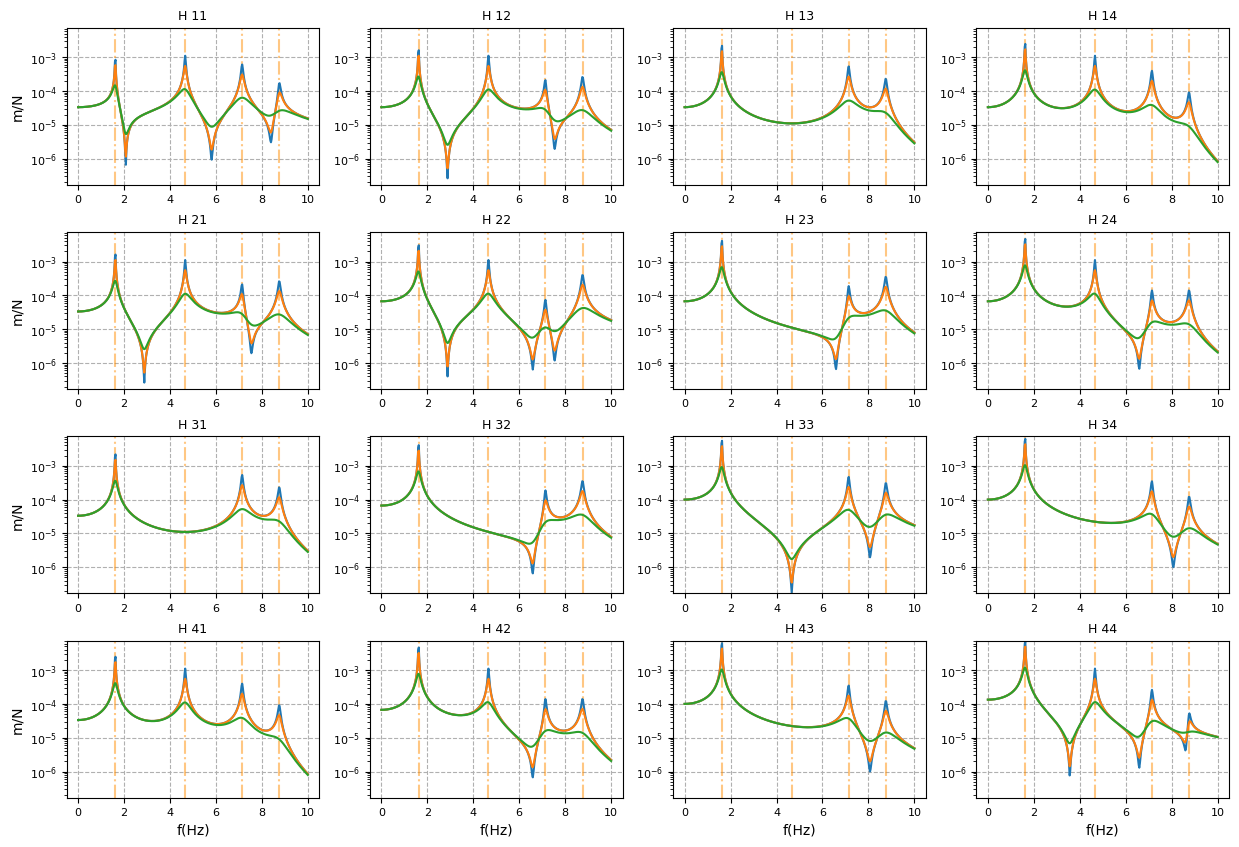

In [6]:
fig, ax = plot_response_magnitude(
    [H_explicit, H_explicit2, H_explicit3],
    freq,
    vertlines=oma1.omega_k / (2 * np.pi),
    figsize=(15, 10),
)

We can see from the figures in the 3th row and 3th column that **the second mode is completly absent**

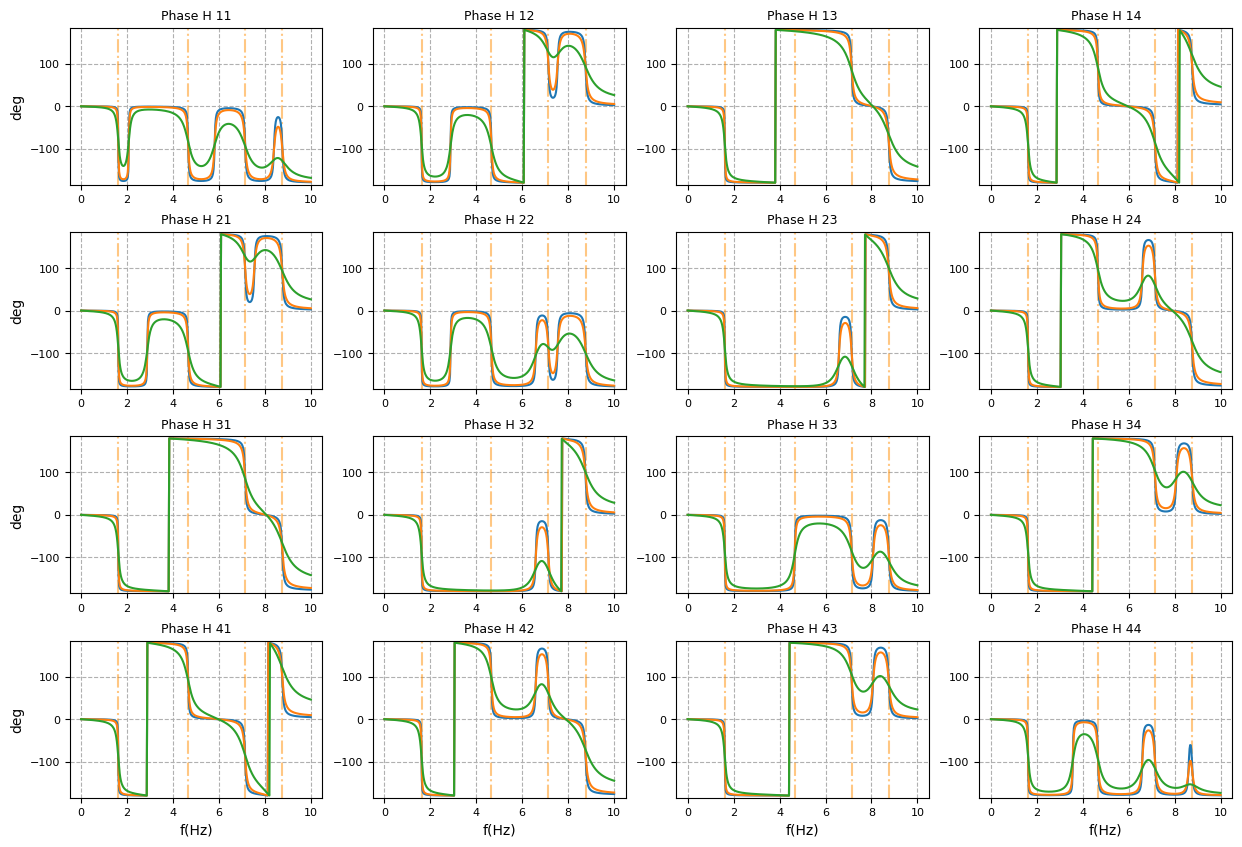

In [7]:
fig, ax = plot_response_phase(
    [H_explicit, H_explicit2, H_explicit3],
    freq, vertlines=oma1.omega_k / (2 * np.pi), figsize=(15, 10)
)

One of the advantages of calculating H explicitly is that we can see the contribution of each of the modes to the transfer funcitons, just use ret_split, to return the response in a split manner. Below there is an example of the H11 function split into contributions

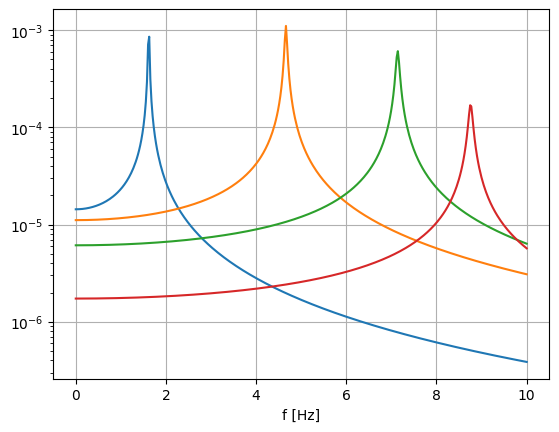

In [8]:
H_split = oma1.response_H_explicit(ww,ret_split=True)

row,col = 0,0
for i in range(H_split.shape[0]):
    plt.plot(freq,np.abs(H_split[i,:,row,col]))

plt.grid(True)
plt.xlabel('f [Hz]')
plt.yscale('log')

We can also calculate the spectrum response, given by:

\begin{equation}
S_{q_{(i,j)}}^{k}(\omega)
= \sum_{r=1}^{n_2} 
\frac{(\varphi_i)_k \, (\varphi_r)_k}{\omega_k^2 - \omega^2 + 2\,i\,\zeta_k\,\omega\,\omega_k}
\cdot R_{prr}
\cdot \frac{(\varphi_j)_k \, (\varphi_r)_k}{\omega_k^2 - \omega^2 - 2\,i\,\zeta_k\,\omega\,\omega_k}
\end{equation}

Where we can specify the stochastic input for each floor, or give a value for all, using the Rp parameter for spectrum response

We will compare these results with the state space model in the next section

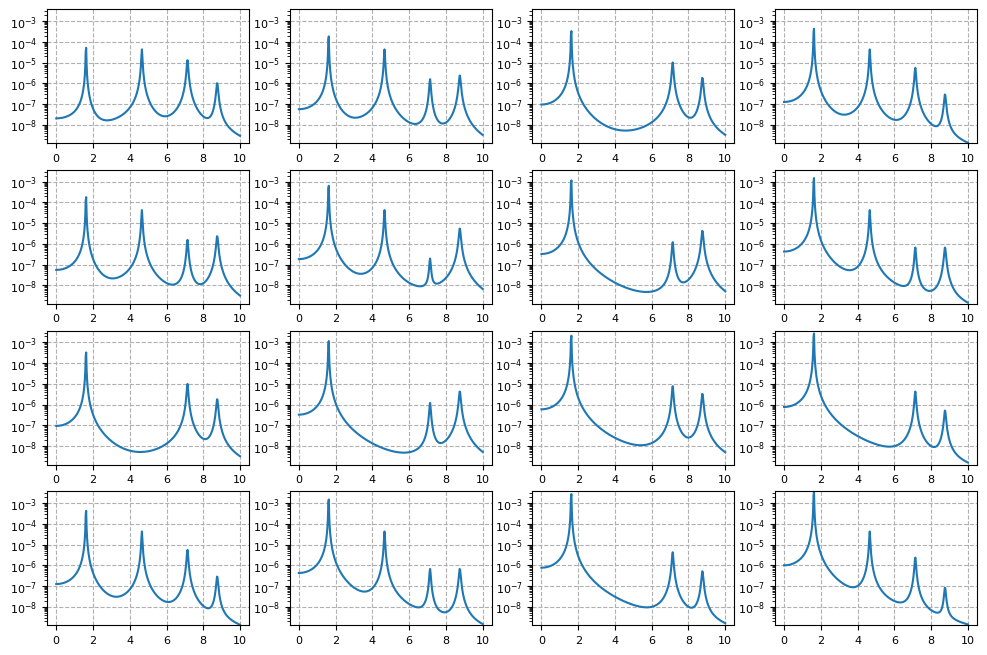

In [9]:
sq = oma1.spectrum_response(ww,rp = np.array([2,1,1,1]))
sqsum = sq.sum(axis=0)

fig,ax = plot_white_noise_response(sqsum,ww/(2*np.pi),figsize=(12,8))

In [10]:
try: #some housekeeping
    del oma1
    del oma2
    del oma3
    print('freeup some space from before')
except:
    print('already deleted')

freeup some space from before


### State Space Model

Now lets inspect the state space formulation of our model we will focus on only one model now.

In [11]:
from ssm import SSM,analyze_timeseries,plot_timeseries_analysis

In [12]:
oma = OperationalModalAnalysis(nf=nf, m=m, k=k,zeta=0.01)
ssm = SSM(oma.M,oma.C,oma.K)

1 DOF frequency (Hz): 4.65957961720501
Natural frequencies (Hz): [1.618 4.66  7.139 8.757]


It is good practice to examine if we have real modes or complex modes, we can see that the modes are real since they fall on a line in the complex plane. In the second figure when a Damper is added to the top of the structure then we have complex modes 

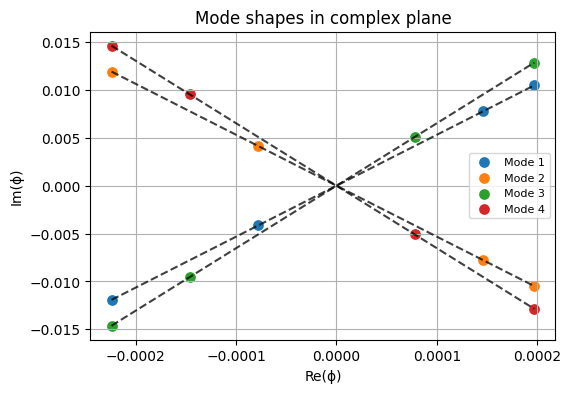

In [13]:
fig,ax = ssm.plot_phi(figsize=(6,4))

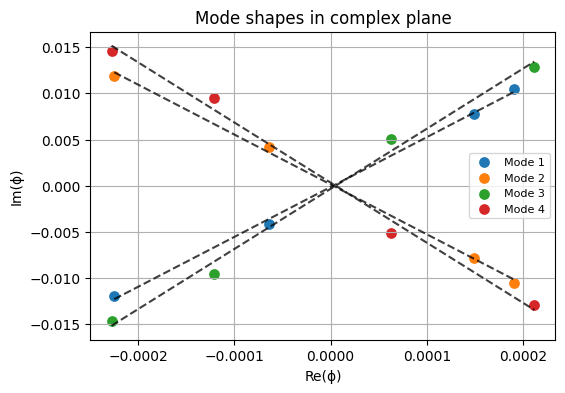

In [14]:
C_extradamp = oma.C.copy()
C_extradamp[-1,-1] = 1.2*C_extradamp[-1,-1]
fig,ax = SSM(oma.M,C_extradamp,oma.K).plot_phi()

ssm provides a wrapper to get the discrete system, based on `signal.cont2discrete`

The availible methods are:
- `gbt` : generalized bilinear transformation
- `bilinear` : Tustin's approximation ("gbt" with alpha=0.5)
- `euler` : Euler (or forward differencing) method ("gbt" with alpha=0)
- `backward_diff` : Backwards differencing ("gbt" with alpha=1.0)
- `zoh` : zero-order hold (default)
- `foh` : first-order hold (versionadded : 1.3.0)
- `impulse` : equivalent impulse response (versionadded: 1.3.0)

The method is relevant for the results, and the default `zoh` is recomended.

It is very important to select the `dt` so that the sampling frequency is higher than the nyquist frequency (double of the max frequency of the signal)

In [15]:
dt = 0.05 #dt in seconds
exp_time = 60*60 #experiment time in seconds
fsample = 1/dt #sampling frequency
nperseg = 512 # number of samples per window segment used for welch methods
print(f"Max expected freq: {np.max(oma.omega_k)/(2*np.pi):2.2f} Hz")
print(f"Nyquist freq:      {2*np.max(oma.omega_k)/(2*np.pi):2.2f} Hz")
print(f"Sample freq:       {fsample} Hz")

dsys = ssm.get_discrete_system(dt=dt,method='zoh')

# random excitation with zero mean
u = 1-2*np.random.rand(int(exp_time/dt), ssm.n) #exptime/dt is the number of points
t,y,x = signal.dlsim(dsys,u) # perform the simulation

Max expected freq: 8.76 Hz
Nyquist freq:      17.51 Hz
Sample freq:       20.0 Hz


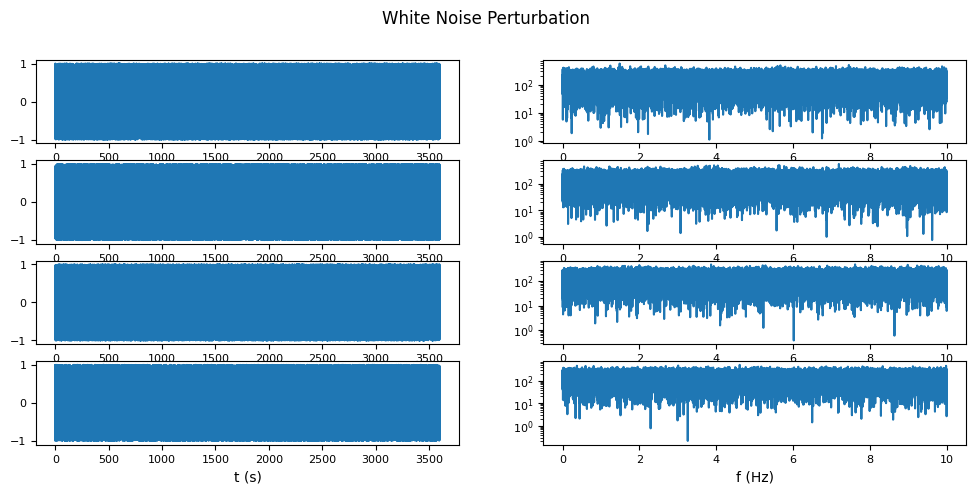

In [16]:
results = analyze_timeseries(u, dt, compute_psd=False, detect_psd_peaks=False,nperseg=nperseg)
fig, axes = plot_timeseries_analysis(results, log_y=True,figsize=(12,5),dt=dt)
fig.suptitle('White Noise Perturbation')
plt.show()

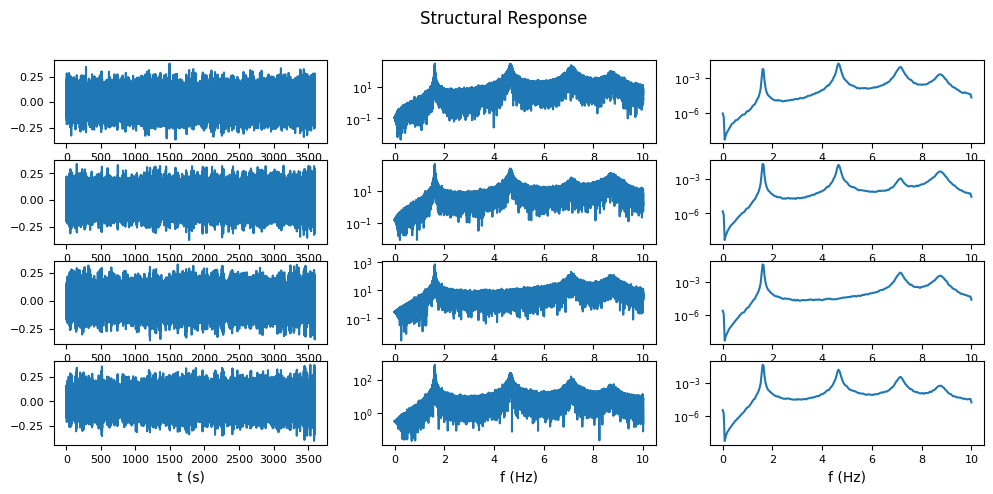

In [17]:
results = analyze_timeseries(y, dt, compute_psd=True, detect_psd_peaks=False,nperseg=nperseg)
fig, axes = plot_timeseries_analysis(results, log_y=True,figsize=(12,5),dt=dt)
fig.suptitle('Structural Response')
plt.show()

We can see clearly in the structural response for the 3th node that the second mode is missing as theorized in the before section

In [18]:
# Display the data provided by analyze time series
results[0].keys()

dict_keys(['time_series', 'fft_freq', 'fft', 'psd_freq', 'psd'])

Next we compare the ssm response with the theoretical spectral response (note that this one must be multiplied by the frequency squared). The results show agreement between the two as expected

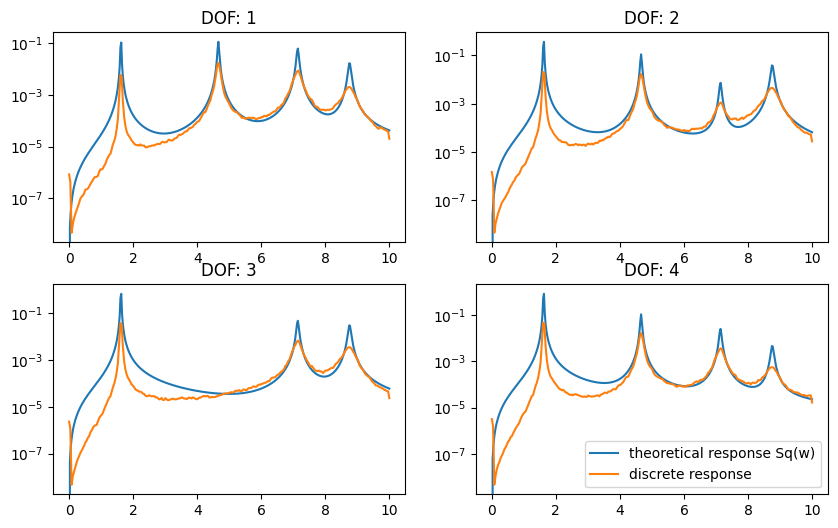

In [19]:
theoryresp = np.abs(sqsum.sum(axis=1))

fig,ax = plt.subplots(2,int(np.ceil(len(results)/2)),figsize=(10,6))
ax = ax.flatten()
for i,r in enumerate(results):
    ax[i].plot(freq,theoryresp[:,i]*(ww**2),label='theoretical response Sq(w)')
    ax[i].plot(r['psd_freq'],r['psd'],label='discrete response')
    ax[i].set_title(f'DOF: {i+1}')
    ax[i].set_yscale('log')
ax[i].legend()
plt.show()

From the SSM eigenvalues we calculate the **Expected Damping Ratios** and present them as follows:

In [20]:
expected_damping_rate = [-eg.real/np.abs(eg) for eg in ssm.eigvals[::-2]]
df_modal_params = pd.DataFrame()

df_modal_params['freq_hz'] = oma.omega_k/(2*np.pi)
df_modal_params['zeta'] = expected_damping_rate

print("Natural frequencies (Hz) and expected damping ratios:\n")
df_modal_params

Natural frequencies (Hz) and expected damping ratios:



,freq_hz,zeta
0,1.618255,0.003473
1,4.659580,0.010000
2,7.138890,0.015321
3,8.757145,0.018794


## Peak-Picking Method

In [21]:
from scipy.signal import find_peaks,csd

from utils import estimate_damping_ratios_half_power,get_modes_from_Tref,plot_modes, plot_spectral_components

In [22]:
anspd = np.sum([r['psd']/r['psd'].sum() for r in results],axis=0)/len(results)
# 50% of standard deviation to be considred a potential peak
peaks,_ = find_peaks(anspd,prominence=0.5*np.std(anspd))

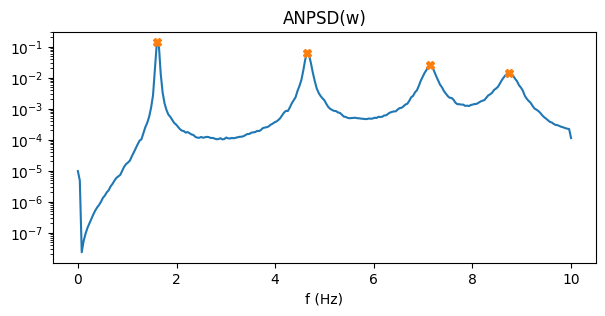

In [23]:
fq = results[0]['psd_freq']
plt.figure(figsize=(7,3))
plt.plot(fq,anspd)
plt.plot(fq[peaks],anspd[peaks],'X')
plt.title('ANPSD(w)')
plt.xlabel('f (Hz)')
plt.yscale('log')

In [24]:
detected_freqs = fq[peaks]
real_freqs = oma.omega_k / (2 * np.pi)

print("Detected vs Real Natural Frequencies:\n")
print(f"{'Detected (Hz)':>15} | {'Closest Real (Hz)':>18} | {'Error (Hz)':>10}")
print("-" * 48)

for f in detected_freqs:
    # Find closest real frequency
    closest = real_freqs[np.argmin(np.abs(real_freqs - f))]
    error = f - closest
    print(f"{f:15.3f} | {closest:18.3f} | {error:10.3f}")


Detected vs Real Natural Frequencies:

  Detected (Hz) |  Closest Real (Hz) | Error (Hz)
------------------------------------------------
          1.602 |              1.618 |     -0.017
          4.648 |              4.660 |     -0.011
          7.148 |              7.139 |      0.010
          8.750 |              8.757 |     -0.007


In [25]:
f0s,damping_ratios_halfpower = estimate_damping_ratios_half_power(anspd, fq, peaks)
print('Peak Picking Damping ratios estimates')
for f0, zeta in zip(f0s,damping_ratios_halfpower):
    print(f"f0 = {f0:.2f} Hz, ζ = {100*zeta:.4f}%")

Peak Picking Damping ratios estimates
f0 = 1.60 Hz, ζ = 2.8535%
f0 = 4.65 Hz, ζ = 1.1447%
f0 = 7.15 Hz, ζ = 1.0674%
f0 = 8.75 Hz, ζ = 1.3732%


In [26]:
df_modal_params['ppm_freq'] = f0s
df_modal_params['ppm_zeta'] = damping_ratios_halfpower
df_modal_params

,freq_hz,zeta,ppm_freq,ppm_zeta
0,1.618255,0.003473,1.601562,0.028535
1,4.659580,0.010000,4.648438,0.011447
2,7.138890,0.015321,7.148438,0.010674
3,8.757145,0.018794,8.750000,0.013732


The damping is overestimated by up to one order of magnitude, which is not negligeable. And the frequencies are estimated accurately. Now we can proceed to estimate the mode shapes by calculating the cross-spectral density matrix and the transfer function matrix

In [27]:
# Calculate cross-spectral density matrix
noutputs = y.shape[1]  # number of outputs
Sy = np.zeros((len(results[0]['psd_freq']), noutputs, noutputs), dtype=complex)

for i in range(noutputs):
    for j in range(noutputs):
        f, Pxy = csd(y[:,i], y[:,j], fs=fsample, nperseg=nperseg)
        Sy[:,i,j] = Pxy

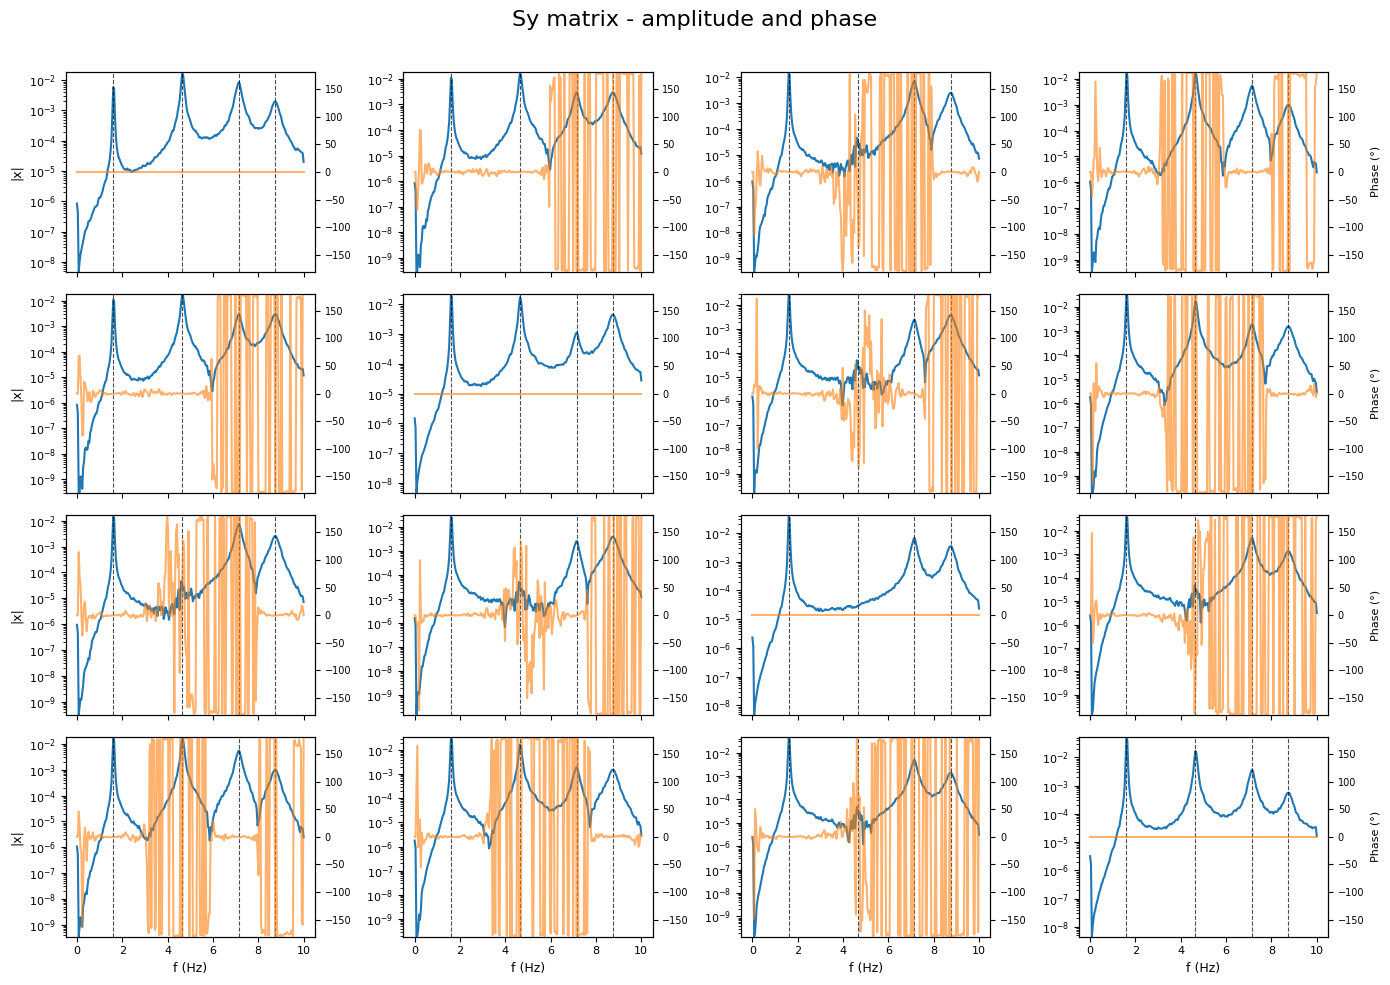

In [28]:
fig,ax = plot_spectral_components(Sy,fq,detected_freqs, suptitle="Sy matrix - amplitude and phase")

In [29]:
Tref = np.copy(Sy[:,:,:])
for i in range(Tref.shape[1]):
    for j in range(Sy.shape[2]):
        Tref[:,i,j] = Tref[:,i,j]/Sy[:,j,j]

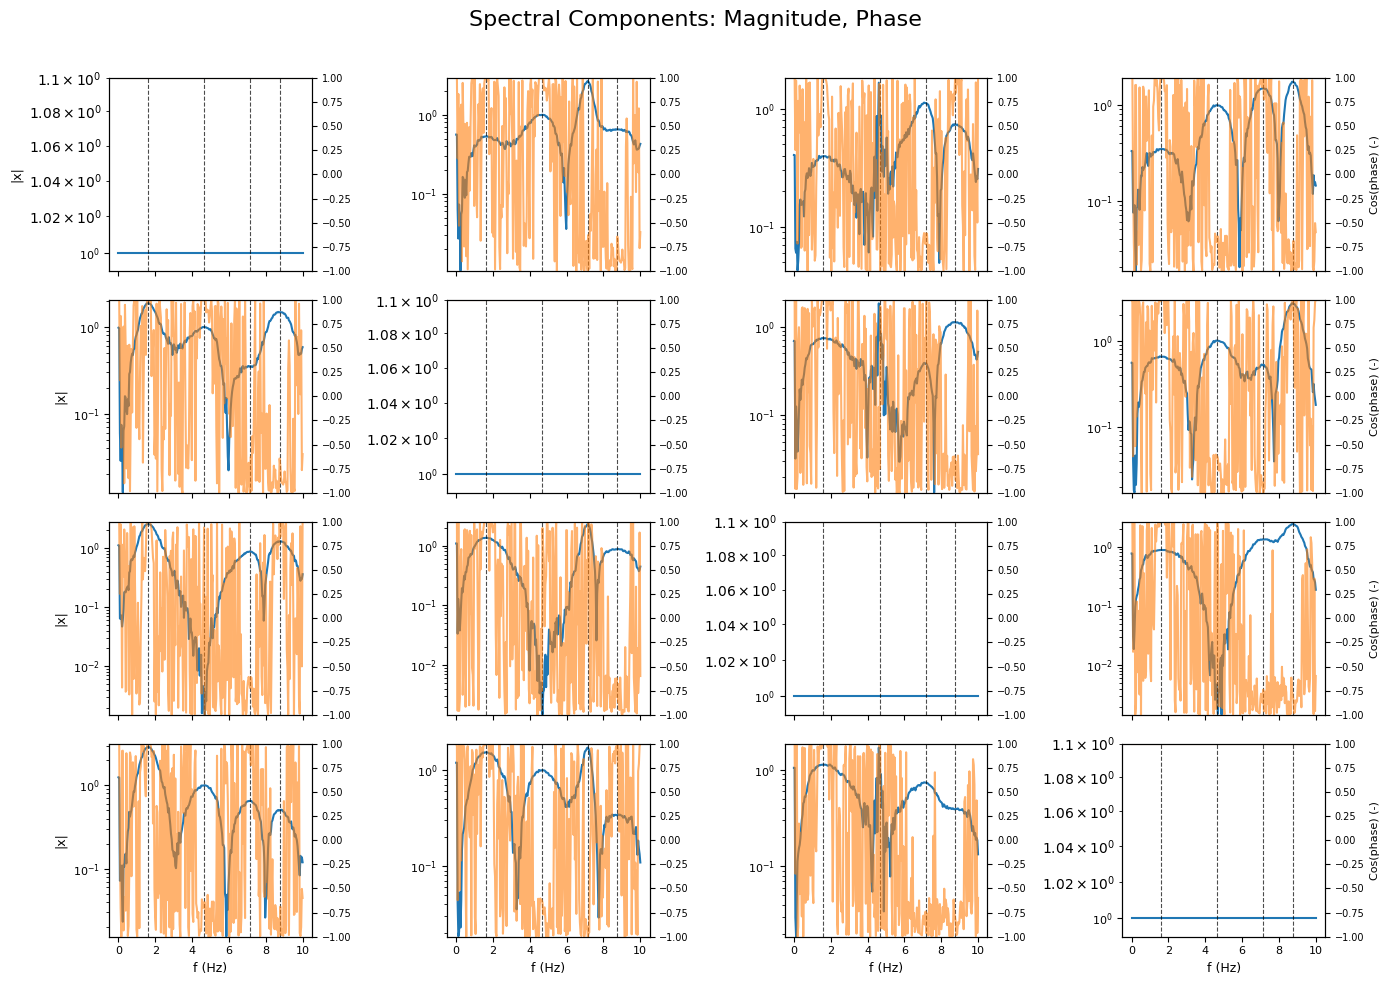

In [30]:
fig,ax = plot_spectral_components(Tref,fq,detected_freqs,cos_of_phase=True)

From each of the Tref matrix columns we can extract the mode shapes, here we present a comparison between all the columns. We can see that with the 3rd column the modes are missrepresented, this is again due to the zero node, so it is important to choose the column correctly. This shows that the pickpeaking method has some reliance on human observation

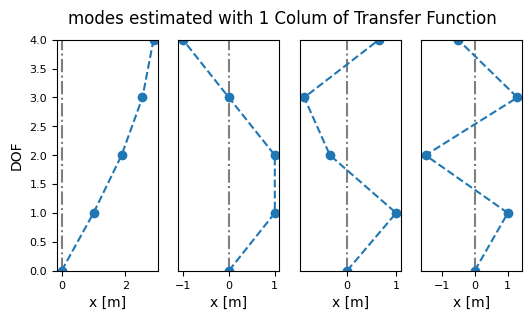

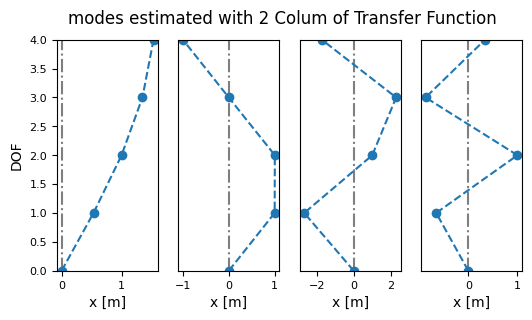

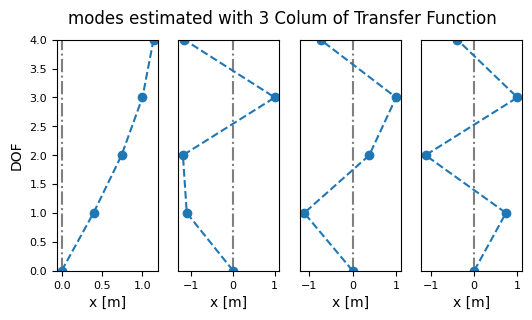

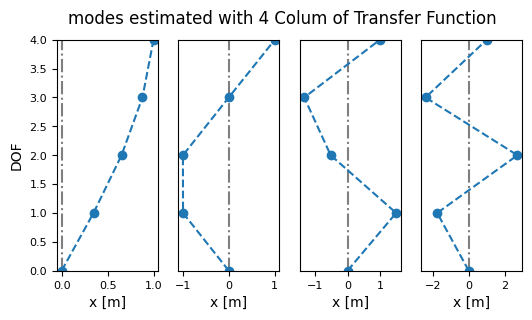

In [31]:
for col in range(Tref.shape[1]):
    modeshapes = get_modes_from_Tref(Tref,peaks,ref_col=col)
    mode_arr = np.array([ i['mode'] for i in modeshapes]).T

    fig,ax = plot_modes(mode_arr,figsize=(6,3))
    fig.suptitle(f'modes estimated with {col+1} Colum of Transfer Function')

### Frequency Domain Decomposition FDD

The FDD method build on the cross spectral density matrix calculated before and on SVD decomposition

In [32]:
from fdd import sy_svd,get_SDOFbell_indices,mac_matrix,max_min_envelope,SDOFbells_to_timedomain,plot_time_signals_with_envelopes

In [33]:
s_w,u_w = sy_svd(Sy)
peaks,_ = find_peaks(s_w[:,0],prominence=0.5*np.std(s_w[:,0]))


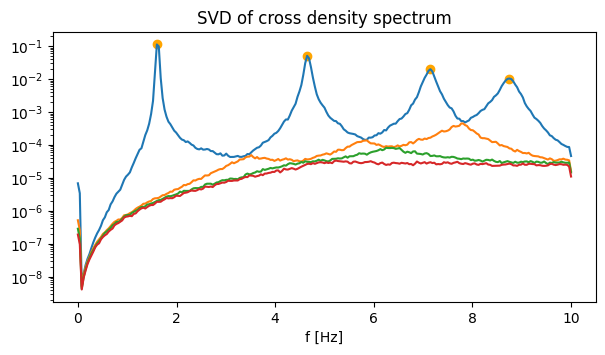

In [34]:
plt.figure(figsize=(7,3.5))
plt.plot(fq,s_w)
plt.yscale('log')
plt.scatter(fq[peaks],s_w[peaks,0],color='orange')
plt.xlabel('f [Hz]')
plt.title('SVD of cross density spectrum')
plt.show()

The mode extraction is straightforward from the SVD decomposition

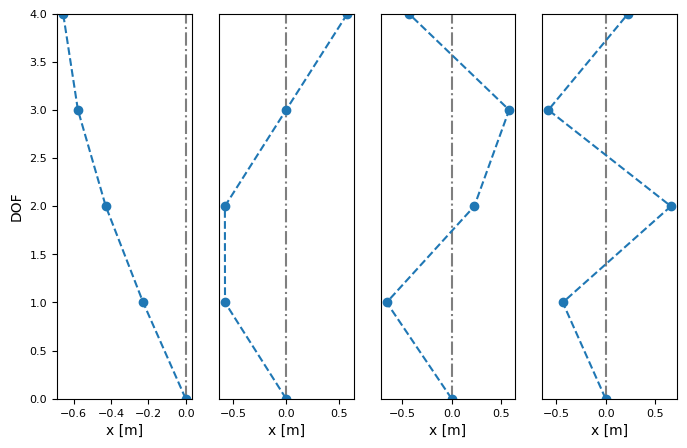

In [35]:
phis = u_w[peaks,:].T

fig,ax = plot_modes(np.cos(np.angle(phis))*np.abs(phis))

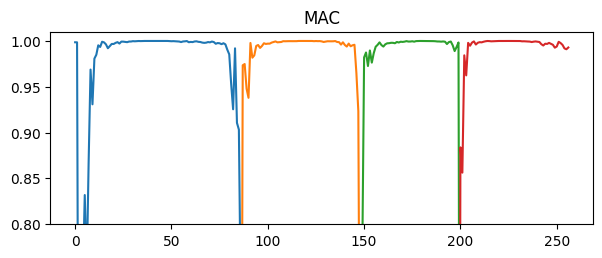

In [36]:
mac_arr = mac_matrix(phis,u_w)

plt.figure(figsize=(7,2.5))
plt.plot(mac_arr)
plt.ylim([0.8,1.01])
plt.title('MAC')
plt.show()

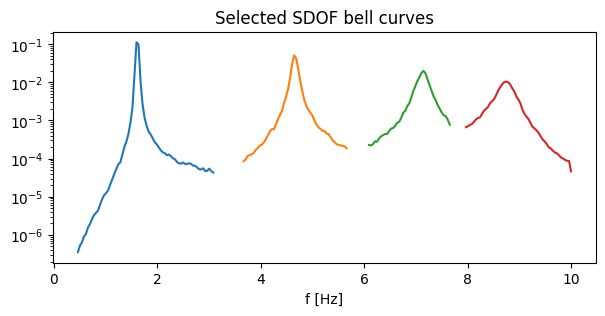

In [37]:
bell_inx = get_SDOFbell_indices(mac_arr,mac_treshold=0.99)
plt.figure(figsize=(7,3))
for sel in bell_inx:
    plt.plot(fq[sel],s_w[sel,0])
plt.yscale('log')
plt.xlabel('f [Hz]')
plt.title('Selected SDOF bell curves')
plt.show()

In [38]:
# Zeropadding is important for the number of datapoints of in the timedomain (may be compared to spline interpolation)
zeropad_factor = 10 
#these thresholds help select the useful part of the envelope
min_amp,max_amp = 0.1,0.8
dtnew = dt/zeropad_factor
time_signal = SDOFbells_to_timedomain(s_w,bell_inx,zeropad_factor)
t_vect = dtnew*np.arange(0,len(time_signal[0]))
envelopes = [max_min_envelope(sdof) for sdof in time_signal]
## SELECT the useful part of the maximum envelope
useful_max = [e[0][np.logical_and(time_signal[i][e[0]]<max_amp,time_signal[i][e[0]]>min_amp)] for i,e in enumerate(envelopes)]

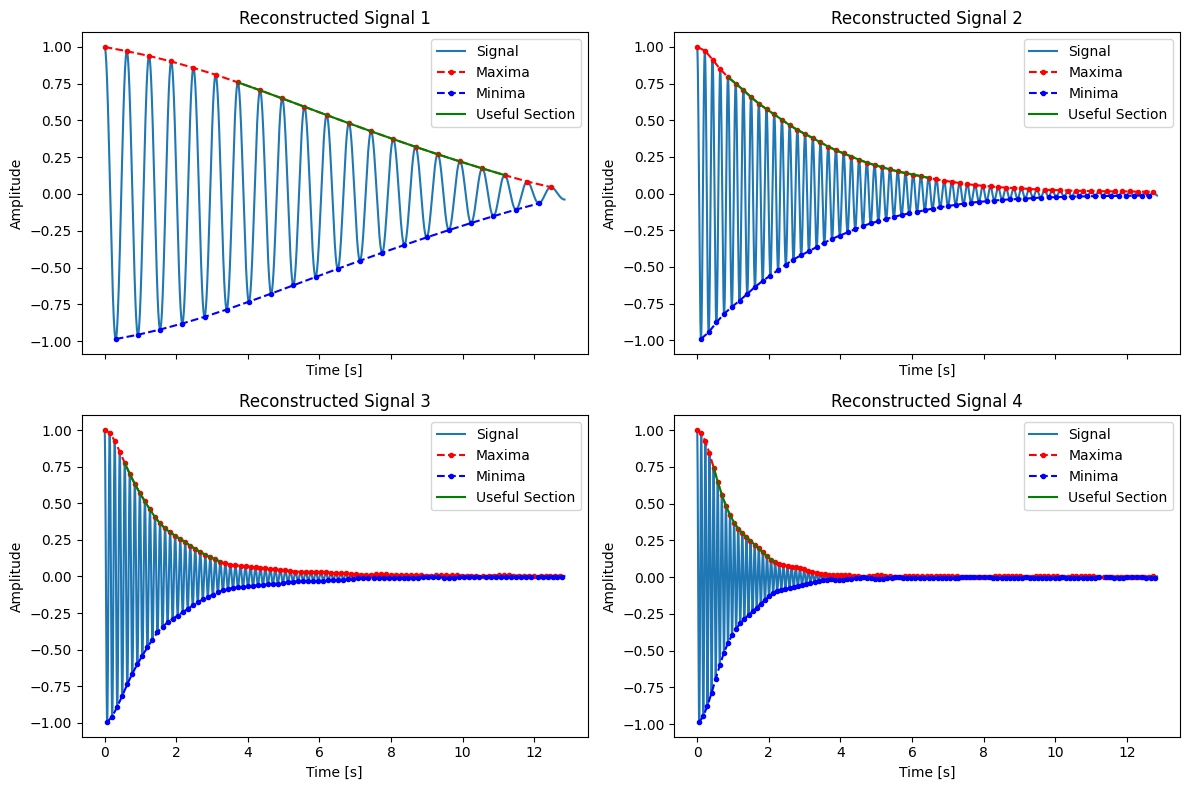

In [39]:
fig,axes = plot_time_signals_with_envelopes(time_signal,envelopes,t_vect,show_minima=True)
for i,ax in enumerate(axes):
    ax.plot(t_vect[useful_max[i]],time_signal[i][useful_max[i]],label='Useful Section',color='g')
    ax.legend()

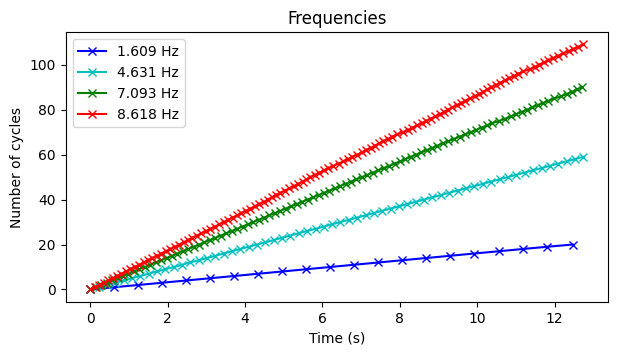

In [40]:
clrs = 'bcgr'
est_freqs = []

plt.figure(figsize=(7,3.5))
plt.title('Frequencies')
for i,sdof in enumerate(time_signal):
    t = t_vect[envelopes[i][0]]
    ncicles = np.arange(len(envelopes[i][0]))
    slope, intercept = np.polyfit(t, ncicles, 1)
    est_freqs.append(slope)
    plt.plot(t,ncicles,'x-',color=clrs[i],label=f'{slope:2.3f} Hz')
plt.legend()
plt.ylabel('Number of cycles')
plt.xlabel('Time (s)')
plt.show()

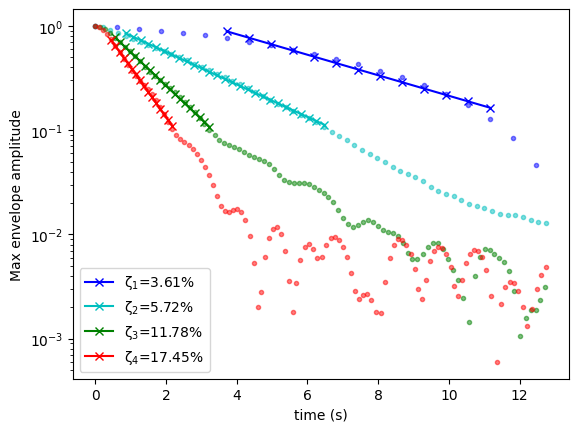

In [41]:
estimated_damping_fdd = []
plt.figure()
for i,sdof in enumerate(time_signal):
    plt.plot(t_vect[envelopes[i][0]],sdof[envelopes[i][0]],'.',color=clrs[i],alpha=0.5)
    # Get useful data points
    t_useful = t_vect[useful_max[i]]
    y_useful = np.log(np.abs(sdof[useful_max[i]]))
    
    # Fit line
    slope, intercept = np.polyfit(t_useful, y_useful, 1)
    fit_line = np.exp(slope * t_useful + intercept)
    estimated_damping_fdd.append(-slope/(2*np.pi))
    # Plot fit line
    plt.plot(t_useful, fit_line, 'x-', label=f'ζ$_{i+1}$={-100*slope/(2*np.pi):2.2f}%',color=clrs[i])

plt.yscale('log')
plt.xlabel('time (s)')
plt.ylabel('Max envelope amplitude')

# Calculate and plot linear fit for each SDOF on useful_max points
plt.legend()
plt.show()

In [42]:
df_modal_params['fdd_freq'] = est_freqs
df_modal_params['fdd_zeta'] = estimated_damping_fdd
df_modal_params

,freq_hz,zeta,ppm_freq,ppm_zeta,fdd_freq,fdd_zeta
0,1.618255,0.003473,1.601562,0.028535,1.608875,0.036101
1,4.659580,0.010000,4.648438,0.011447,4.631183,0.057226
2,7.138890,0.015321,7.148438,0.010674,7.093299,0.117781
3,8.757145,0.018794,8.750000,0.013732,8.618238,0.174518


We can see that the frequencies are identified correctly with the FDD method but that the **damping ratios are overestimated by over an order of magnitude**, which is not a satisfying result. The implementation was double checked but I was enable to attribute this overestimation to an error in the code, further revision is still necesary to understand the reason behind.

### SSICOV

The SSI covariance method is a time domain based method that relies on the Toeplitz matrix of autocorrelations

here is the list of input parameters to the implemented class

| Variable | Typical Name       | Physical Meaning                                       |
| -------- | ------------------ | ------------------------------------------------------ |
| acc      | Acceleration       | Measured acceleration data (array: samples × channels) |
| fs       | Sampling Frequency | Number of samples per second (Hz)                      |
| time sample       | Time Interval      | Duration (in seconds) for IRF calculation     |
| Nmax     | Max Model Order    | Maximum number of system modes/states to consider      |
| Nmin     | Min Model Order    | Minimum number of system modes/states to consider      |


In [43]:
from ssicov import SSICOV,explode_stability_df,plot_stabilization_diagram
from sklearn.cluster import DBSCAN
from utils import plot_modes

For the sake of clarity I've re created the ssm model again since the variable names may have been forgotten by now, but  this step is not necessary

In [44]:
oma = OperationalModalAnalysis(nf=nf, m=m, k=k, zeta=0.01)

ssm = SSM(oma.M, oma.C, oma.K)
# fig,ax = ssm.plot_phi(figsize=(5,12))

dt = 0.05  # dt in seconds
exp_time =  60 * 60  # experiment time in seconds
fsample = 1 / dt  # sampling frequency
print(f"Sample freq: {fsample} Hz")
print(f"Max expected freq: {np.max(oma.omega_k)/(2*np.pi):2.2f} Hz")

dsys = ssm.get_discrete_system(dt=dt, method="zoh")
# exptime/dt is the number of points
u = 1 - 2 * np.random.rand(int(exp_time / dt), ssm.n)
t, y, x = signal.dlsim(dsys, u)

1 DOF frequency (Hz): 4.65957961720501
Natural frequencies (Hz): [1.618 4.66  7.139 8.757]
Sample freq: 20.0 Hz
Max expected freq: 8.76 Hz


The SSICOV method class can be entirely run with one function call. behind the scenes four main things occurr:
1. IRF calculation in the frequency domain
2. Assembly of the Toeplitz block matrix
3. SVD of the Toeplitz matrix
4. Calculation of the stabilization diagram

The SVD is quite resource inensive so an implementation of the randomized svd as proposed in this [article](https://doi.org/10.1016/j.ymssp.2024.112264) is included and can be opted in, this allows for larger time sample periods and faster computation. This becomes relevant for larger time_sample intervals

The stability diagram is returned as a convinient DataFrame


In [45]:
# # this is a dummy run just because the toeplitz matrix is JITed so the following calculations are a fair comparison
ssicov = SSICOV(y, fsample, time_sample=1, nmin=2, nmax=30) 
df_stability = ssicov.run(random_svd=False)

In [46]:
ssicov = SSICOV(y, fsample, time_sample=90, nmin=2, nmax=30)
df_stability = ssicov.run(random_svd=False)

In [47]:
ssicov = SSICOV(y, fsample, time_sample=90, nmin=2, nmax=30)
df_stability = ssicov.run(random_svd=True)

The above code execution times hint that the randomized SVD can significantly faster as the time sample gets higher

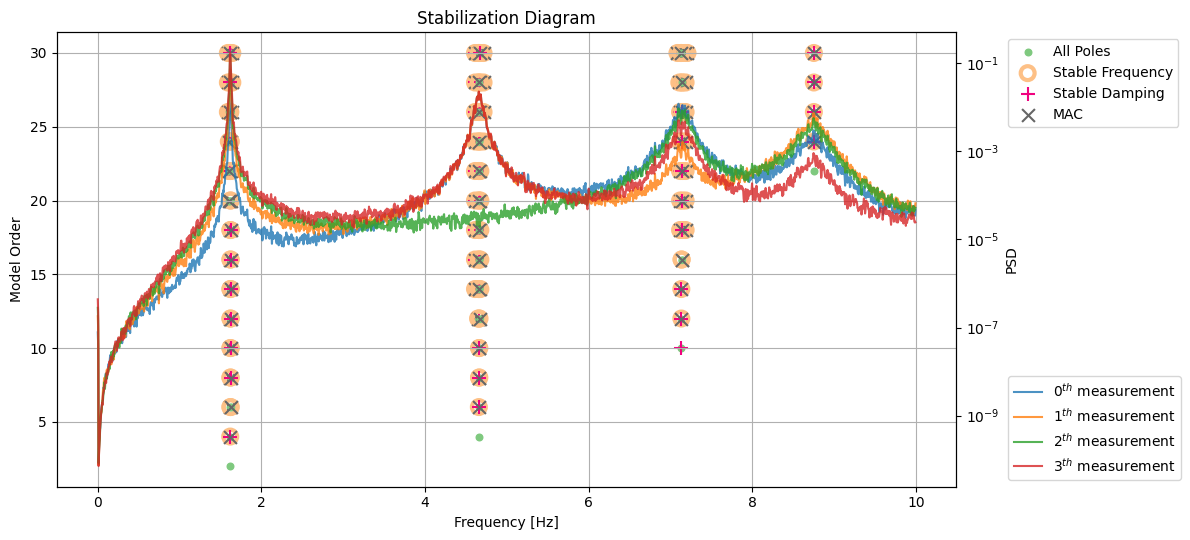

In [48]:
fig,ax = plot_stabilization_diagram(df_stability,figsize=(12,5.5))

ax_fft = ax.twinx()  # create a second x-axis on top
for j in range(y.shape[1]):
    [freqs,Pxx] = welch(y[:,j],fs=fsample,nperseg=4096)
    if j == 0 :
        idxcut = np.argmin(np.abs(freqs-round(ax.get_xlim()[1]+1)))
    ax_fft.plot(freqs[:idxcut], Pxx[:idxcut], alpha=0.8, label=f"{j}"+"$^{th}$ measurement")
ax_fft.set_xlim(ax.get_xlim())
ax_fft.set_yscale('log')
ax_fft.set_ylabel("PSD")
ax_fft.legend(bbox_to_anchor=(1.05, 0), loc='lower left')

plt.show()

From the stability diagram we cluster the poles , using DBSCAN, based on frequency and damping 

In [49]:
dfs = explode_stability_df(df_stability)
dfs_filter = dfs[np.logical_and(dfs['status']>2,dfs['zeta']>0)].copy()
dfs_filter = dfs_filter.sort_values(['status'],axis=0,ascending=False).sort_values(['mo'],axis=0)
dfs_filter['clusterid'] = DBSCAN().fit_predict(dfs_filter[['freqs','zeta']].values)

In [50]:
_tmp_sel = []
for i in dfs_filter['clusterid'].unique():
    _tmp_sel.append(dfs_filter[dfs_filter['clusterid'] == i].iloc[0])
selected_poles = pd.DataFrame(_tmp_sel)

sel_phi = np.vstack(selected_poles['phi'].values).T
sel_phi = np.cos(np.angle(sel_phi))*np.abs(sel_phi)

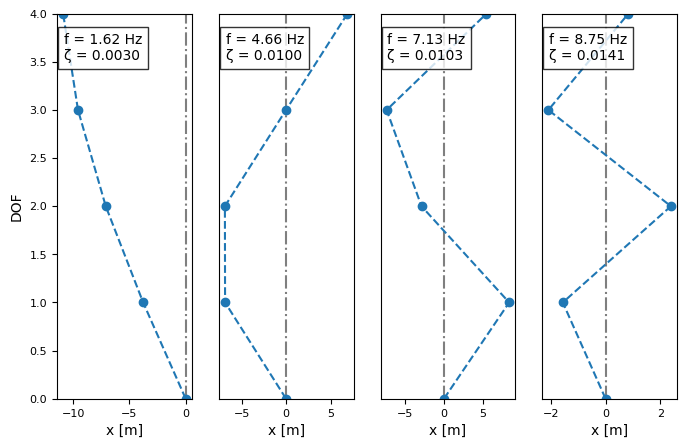

In [51]:
fig,axes = plot_modes(sel_phi)
for i,ax in enumerate(axes):
    ax.annotate(f'f = {selected_poles.iloc[i]["freqs"]:.2f} Hz\nζ = {selected_poles.iloc[i]["zeta"]:.4f}', 
                   xy=(0.05, 0.95), 
                   xycoords='axes fraction',
                   bbox=dict(facecolor='white', alpha=0.8),
                   verticalalignment='top')

In [52]:
df_modal_params['ssicov_freq']=selected_poles["freqs"].values
df_modal_params['ssicov_zeta']=selected_poles["zeta"].values

In [53]:
df_modal_params

,freq_hz,zeta,ppm_freq,ppm_zeta,fdd_freq,fdd_zeta,ssicov_freq,ssicov_zeta
0,1.618255,0.003473,1.601562,0.028535,1.608875,0.036101,1.618913,0.002977
1,4.659580,0.010000,4.648438,0.011447,4.631183,0.057226,4.658340,0.010025
2,7.138890,0.015321,7.148438,0.010674,7.093299,0.117781,7.133599,0.010252
3,8.757145,0.018794,8.750000,0.013732,8.618238,0.174518,8.753755,0.014078


In [54]:
# Compute relative errors
methods = ['ppm', 'fdd', 'ssicov']
errors = []

for i in range(len(df_modal_params)):
    true_freq = df_modal_params.loc[i, 'freq_hz']
    true_zeta = df_modal_params.loc[i, 'zeta']
    for method in methods:
        freq_est = df_modal_params.loc[i, f'{method}_freq']
        zeta_est = df_modal_params.loc[i, f'{method}_zeta']

        freq_error = abs(freq_est - true_freq) / true_freq * 100
        zeta_error = abs(zeta_est - true_zeta) / true_zeta * 100

        errors.append({
            'Mode': i + 1,
            'Method': method.upper(),
            'Freq_error_%': freq_error,
            'Zeta_error_%': zeta_error
        })

# Create results DataFrame
errors_df = pd.DataFrame(errors)

# Optional: round for readability
errors_df[['Freq_error_%', 'Zeta_error_%']] = errors_df[['Freq_error_%', 'Zeta_error_%']].round(2)

print('Modal parameter estimation error comparision')
errors_df.sort_values(by='Zeta_error_%')

Modal parameter estimation error comparision


,Mode,Method,Freq_error_%,Zeta_error_%
5,2,SSICOV,0.03,0.25
2,1,SSICOV,0.04,14.29
3,2,PPM,0.24,14.47
11,4,SSICOV,0.04,25.09
9,4,PPM,0.08,26.93
6,3,PPM,0.13,30.33
8,3,SSICOV,0.07,33.08
4,2,FDD,0.61,472.26
7,3,FDD,0.64,668.76
0,1,PPM,1.03,721.62


To summarize the different modal identification methods provide a good estimation for the natural frequencies, with errors not often larger than 1%, but even in that regard **SSICOV proves supperior**, with the lowest errors. Then the estimation of the damping ratios is where SSICOV really excells, with errors lower or around 10%, whereas the other methods go way beyond that mark.

### BONUS nrel 5mw

A real case example to show that the EOM matrices can be assembled by oma for mass and stiffness distribution instead of fixed values

In [55]:
from scipy.interpolate import PchipInterpolator

L = 87.6
z = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# kg/m
mass_density_kg_per_m = [
    5590.87,
    5232.43,
    4885.76,
    4550.87,
    4227.75,
    3916.41,
    3616.83,
    3329.03,
    3053.01,
    2788.75,
    2536.27,
]

stiffness_N_per_m = [
    1.843e09,
    1.604e09,
    1.390e09,
    1.197e09,
    1.026e09,
    8.730e08,
    7.381e08,
    6.194e08,
    5.156e08,
    4.253e08,
    3.475e08,
]

massdensity_interp = PchipInterpolator(L * np.array(z), np.array(mass_density_kg_per_m))
stiffness_interp = PchipInterpolator(L * np.array(z), np.array(stiffness_N_per_m))

In [56]:
nf = 30

m_arr = np.zeros(nf)
k_arr = np.zeros(nf)
zz = np.linspace(0,L,nf+1)

for i in range(nf):
    avg_md = 0.5*(massdensity_interp(zz[i])+massdensity_interp(zz[i+1]))
    avg_k = 0.5*(stiffness_interp(zz[i])+stiffness_interp(zz[i+1]))
    m_arr[i] = avg_md*(zz[i+1]-zz[i])
    # k_arr[i] = avg_k
    k_arr[i] = avg_k*(zz[i+1]-zz[i])/30

m_arr[-1]+=290_000 #nacelle mass
m_arr[-1]+=110_000 #hub plus blades

oma = OperationalModalAnalysis(nf=nf, m=m_arr, k=k_arr, zeta=0.01)

1 DOF frequency (Hz): 9.681040629064832
Natural frequencies (Hz): [ 0.366  1.49   2.849  4.226  5.598  6.958  8.298  9.616 10.906 12.164
 13.386 14.569 15.707 16.797 17.834 18.813 19.729 20.574 21.345 22.052
 22.729 23.418 24.137 24.895 25.699 26.561 27.498 28.531 29.717 31.187]


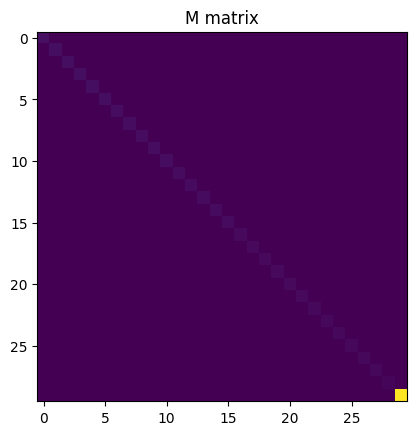

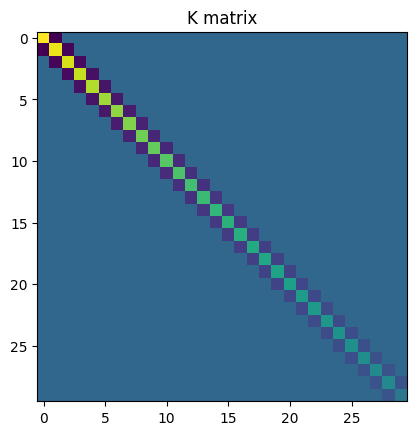

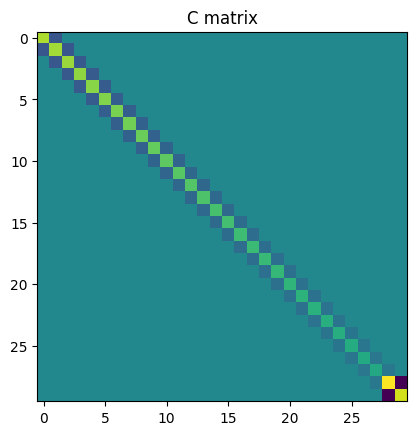

In [57]:
plt.imshow(oma.M)
plt.title('M matrix')
plt.show()
plt.imshow(oma.K)
plt.title('K matrix')
plt.show()
plt.imshow(oma.C)
plt.title('C matrix')
plt.show()


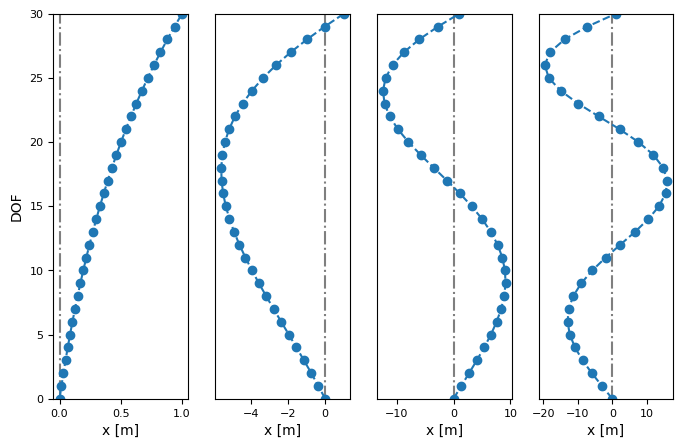

In [58]:
modes = oma.get_modes(normalize=True)[:,:4]

fig,ax = plot_modes(modes,append_zero=False)

In [59]:
ssm = SSM(oma.M, oma.C, oma.K)

dt = 0.05  # dt in seconds
exp_time =  60 * 60  # experiment time in seconds
fsample = 1 / dt  # sampling frequency
print(f"Sample freq: {fsample} Hz")
print(f"Max expected freq: {np.max(oma.omega_k)/(2*np.pi):2.2f} Hz")

dsys = ssm.get_discrete_system(dt=dt, method="zoh")
# exptime/dt is the number of points
u = 1 - 2 * np.random.rand(int(exp_time / dt), ssm.n)
t, y, x = signal.dlsim(dsys, u)

Sample freq: 20.0 Hz
Max expected freq: 31.19 Hz


In [60]:
ssicov = SSICOV(y, fsample, time_sample=40, nmin=2, nmax=30)
df_stability = ssicov.run(random_svd=True)

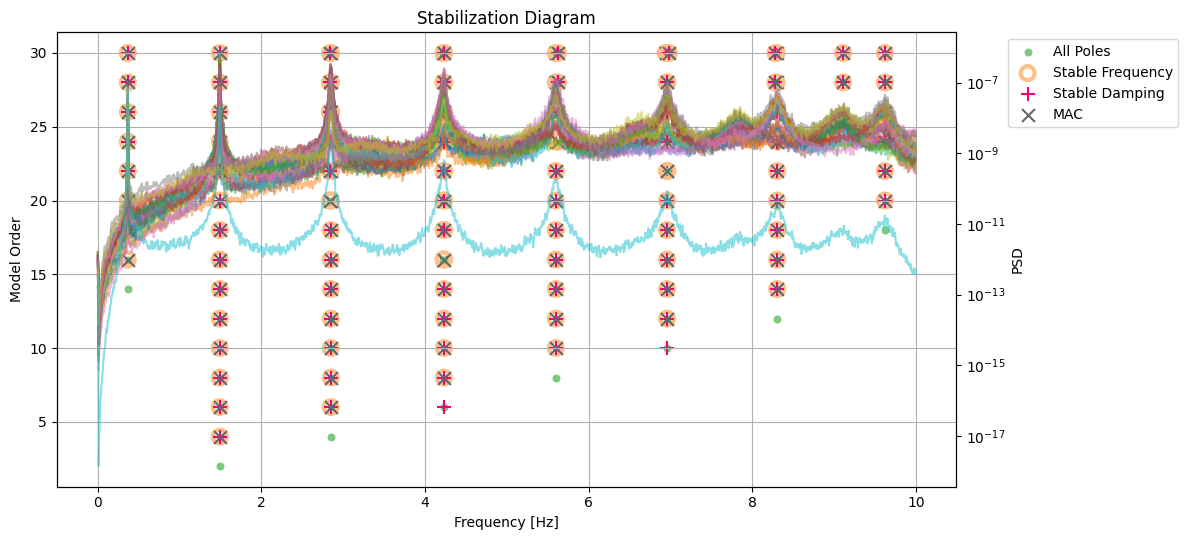

In [61]:
fig,ax = plot_stabilization_diagram(df_stability,figsize=(12,5.5))

ax_fft = ax.twinx()  # create a second x-axis on top
for j in range(y.shape[1]):
    [freqs,Pxx] = welch(y[:,j],fs=fsample,nperseg=4096)
    if j == 0 :
        idxcut = np.argmin(np.abs(freqs-round(ax.get_xlim()[1]+1)))
    ax_fft.plot(freqs[:idxcut], Pxx[:idxcut], alpha=0.5, label=f"{j}"+"$^{th}$ measurement")
ax_fft.set_xlim(ax.get_xlim())
ax_fft.set_yscale('log')
ax_fft.set_ylabel("PSD")
# ax_fft.legend(bbox_to_anchor=(1.05, 0), loc='lower left')

plt.show()

In [62]:
dfs = explode_stability_df(df_stability)
dfs_filter = dfs[np.logical_and(dfs['status']>2,dfs['zeta']>0)].copy()
dfs_filter = dfs_filter.sort_values(['status'],axis=0,ascending=False).sort_values(['mo'],axis=0)
dfs_filter['clusterid'] = DBSCAN().fit_predict(dfs_filter[['freqs','zeta']].values)

_tmp_sel = []
for i in dfs_filter['clusterid'].unique():
    _tmp_sel.append(dfs_filter[dfs_filter['clusterid'] == i].iloc[0])
selected_poles = pd.DataFrame(_tmp_sel)

In [63]:
selected_poles.sort_values(by='freqs')

,mo,freqs,zeta,status,phi,clusterid
29,16,0.366364,0.000430,5,"[(-1.9848492e-06+5.8972593e-05j), (5.3645813e-...",6
1,4,1.490838,0.001669,7,"[(-0.0011482309+0.0002853479j), (-0.0023398243...",0
4,6,2.847873,0.004468,7,"[(-0.0022021118+0.0012617463j), (-0.004472404+...",1
9,8,4.230703,0.004704,7,"[(0.0019145068+0.0028060377j), (0.004041362+0....",2
14,10,5.598218,0.006787,7,"[(-0.0035352258-0.0028728675j), (-0.006770111-...",3
19,12,6.958622,0.006908,7,"[(-0.0024117997+0.0043902076j), (-0.0041938033...",4
26,14,8.304437,0.007912,7,"[(0.00525252+0.0016514705j), (0.009579124+0.00...",5
102,28,9.111072,0.014466,7,"[(0.0015278369-0.005658546j), (0.0030751906-0....",-1
45,20,9.621622,0.010005,7,"[(0.0059039467+2.0679661e-05j), (0.009871718+0...",7


This experiment shows that ssicov can correctly identify modal parameters of complex structures